# Demo with 2 Dimensional Data

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

In [110]:
df = pd.read_csv('https://raw.githubusercontent.com/fangjin/python_summer_example/main/clustering-2/SolarPrediction.csv')
df = df[["Radiation", "Temperature"]]
df.head()


,Radiation,Temperature
0,1.21,48
1,1.21,48
2,1.23,48
3,1.21,48
4,1.17,48


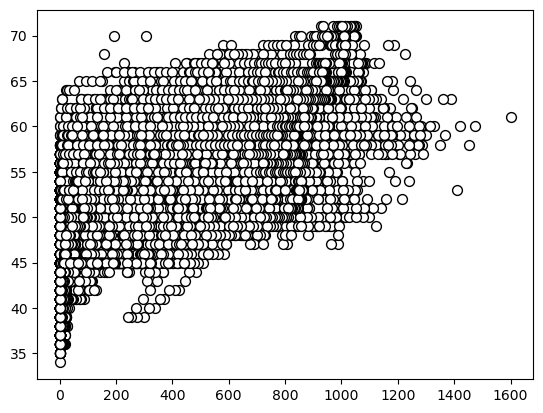

In [111]:
# plot
X = df.to_numpy()
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='o',
   edgecolor='black', s=50
)
plt.show()

In [112]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

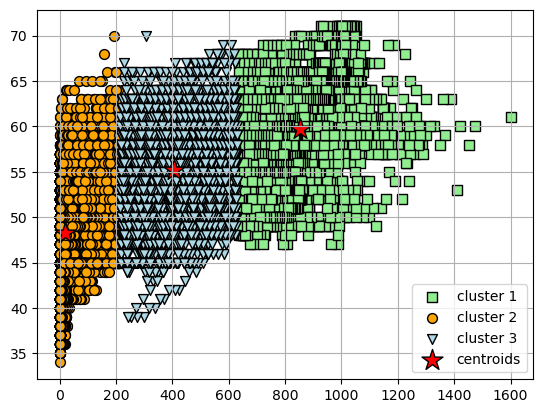

In [113]:
# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [114]:
df = pd.read_csv('https://raw.githubusercontent.com/fangjin/python_summer_example/main/Clustering-dataset/Clustering1.txt', sep='\t')
df.head()

,Column1,Column2,Unnamed: 2
0,15.55,28.65,NaN
1,14.90,27.55,NaN
2,14.45,28.35,NaN
3,14.15,28.80,NaN
4,13.75,28.05,NaN


In [115]:
df.columns

Index(['Column1', 'Column2', 'Unnamed: 2'], dtype='object')

In [116]:
df = df[["Column1", "Column2"]]
df.head()


,Column1,Column2
0,15.55,28.65
1,14.90,27.55
2,14.45,28.35
3,14.15,28.80
4,13.75,28.05


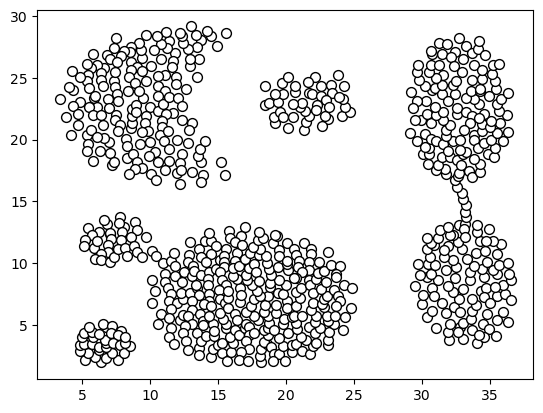

c:\Users\hydro\anaconda3\envs\cov\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


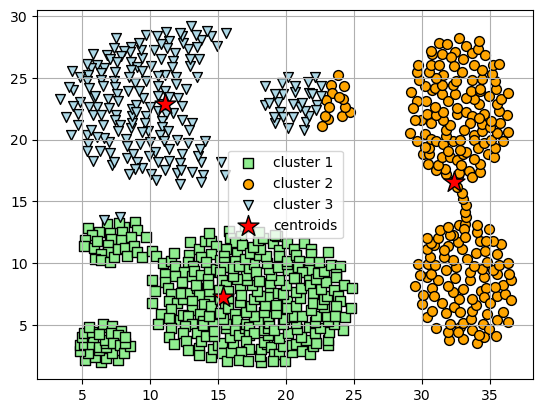

In [117]:
# plot
X = df.to_numpy()
plt.scatter(
   X[:, 0], X[:, 1],
   c='white', marker='o',
   edgecolor='black', s=50
)
plt.show()

from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [118]:
%matplotlib inline


# A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in
terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality
metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see `clustering_evaluation` for
definitions and discussions of the metrics):

=========== ========================================================
Shorthand    full name
=========== ========================================================
homo         homogeneity score
compl        completeness score
v-meas       V measure
ARI          adjusted Rand index
AMI          adjusted mutual information
silhouette   silhouette coefficient
=========== ========================================================


## Load the dataset

We will start by loading the `digits` dataset. This dataset contains
handwritten digits from 0 to 9. In the context of clustering, one would like
to group images such that the handwritten digits on the image are the same.



In [119]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to
compare different initialization methods for KMeans. Our benchmark will:

* create a pipeline which will scale the data using a
  :class:`~sklearn.preprocessing.StandardScaler`;
* train and time the pipeline fitting;
* measure the performance of the clustering obtained via different metrics.



In [120]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Run the benchmark

We will compare three approaches:

* an initialization using `kmeans++`. This method is stochastic and we will
  run the initialization 4 times;
* a random initialization. This method is stochastic as well and we will run
  the initialization 4 times;
* an initialization based on a :class:`~sklearn.decomposition.PCA`
  projection. Indeed, we will use the components of the
  :class:`~sklearn.decomposition.PCA` to initialize KMeans. This method is
  deterministic and a single initialization suffice.



In [121]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.173s	69662	0.680	0.719	0.699	0.570	0.695	0.184


c:\Users\hydro\anaconda3\envs\cov\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\hydro\anaconda3\envs\cov\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


random   	0.180s	69707	0.675	0.716	0.694	0.560	0.691	0.168
PCA-based	0.070s	72686	0.636	0.658	0.647	0.521	0.643	0.157
__________________________________________________________________________________


c:\Users\hydro\anaconda3\envs\cov\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


## Visualize the results on PCA-reduced data

:class:`~sklearn.decomposition.PCA` allows to project the data from the
original 64-dimensional space into a lower dimensional space. Subsequently,
we can use :class:`~sklearn.decomposition.PCA` to project into a
2-dimensional space and plot the data and the clusters in this new space.



c:\Users\hydro\anaconda3\envs\cov\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


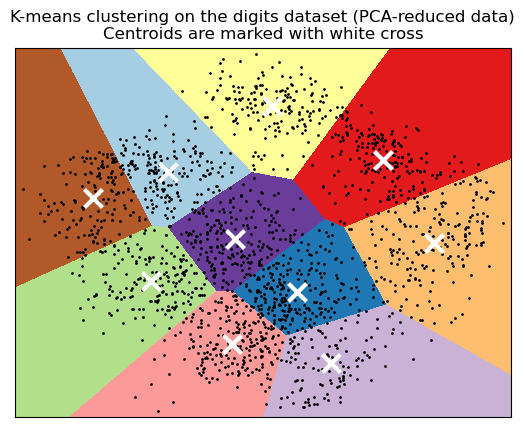

In [122]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()